# Projet Notations de films 

Dans le cadre du Projet Data Science nous avons choisi d'étudier l'appréciation des films par les spectateurs et la presse, à partir de leur notation.

problématique : Quelles caractéristiques des films font qu'ils sont les mieux notés ?
                Peut-on prévoir l'appréciation des films sans se baser sur le résumé ?
                Peut-on prévoir l'appréciation des films ?
                Existe-t-il une différence significative de notation des films selon le genre du réalisateur ?

Le rapport se décompose de la manière suivante :   

I - Création de la base de données

1) Webscrapping du site Allocine

2) Traitement de la base et création de variables 

3) Base CNC


II - Analyses descriptive des données

1) Analyses générales sur les notes attribuées aux films en fonction du genre du films

2) Analyses sur d'autres variables

3) Comparaison appréciation spectateurs vs presse

4) Analyses plus subtiles sur le genre et le budget


III - Modélisation

1) spectateurs : modèle de prediction des notes à partir de caractéristiques des films

2) presse : clustering sur les films français CNC


In [1]:
# Installation des packages nécessaires au projet        A supprimer avant d'envoyer  # un fichiers requirements.txt est présent pour le projet
!pip install ipywidgets

!pip install lxml
!pip install aiohttp
!pip install nest_asyncio
!pip install unidecode

### Importation des librairies et des fichiers

In [2]:
# installation nécessaire non mise dans requirements.txt
!jupyter nbextension enable --py widgetsnbextension 

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [3]:
# Importation des librairies
import csv
import os
import s3fs

# 
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re
import nest_asyncio
from scipy.stats import shapiro



In [4]:
# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")


for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")


for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### Webscrapping AlloCiné

=========================== Expliquer en quelques lignes les grands étapes réalisés par webscrapping

In [ ]:
# Récupération d'une liste de films qui possèdent tous une note moyenne de spectateur et une note moyenne de presse




In [70]:
# Lecture de la base CSV (sauvegardée dans le SSP Cloud car webscrapping qui prend un peu de temps (et les données changent régulièrement)) :

# Création du chemin
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "roux"
fs.ls(MY_BUCKET)
chemin = f"{MY_BUCKET}/base_final_v2.csv"

# Importation
with fs.open(chemin, "r") as file_in:
    table_films = pd.read_csv(file_in)

**Si le code précédent ne fonctionne pas (mettre à jour les jetons, ou bien dé-commenter et exécuter le code suivant) :**

In [ ]:
# Si ne fonctionne pas 
# url = "https://minio.lab.sspcloud.fr/roux/base_final_v2.csv"
# import pandas as pd
# table_films = pd.read_csv(url)

### Traitement de la base (Mise en forme et création de variables)

Base de films Allociné

In [ ]:
####### Nettoyage et mise en forme

# Conversion des notes en écriture décimale
table_films['spectators_rating'] = table_films['spectators_rating'].apply(mise_en_forme_decimale)
table_films['press_rating'] = table_films['press_rating'].apply(mise_en_forme_decimale)




######## Créations de variables

# Ajout du genre des réalisateurs (en se basant sur une base de plus de 11 627 prénoms de plusieurs pays dont le genre est mentionné)
table_films = get_genre_individuel(table_films, 'director')

# Différence de notation entre spectateur et presse
table_films['diff_notation'] = table_films['spectators_rating']-table_films['press_rating']

# Année du film
table_films = get_annee(table_films, 'date')               

# Durée du film en minutes
table_films['duration'] = table_films['duration'].astype('string')
table_films['duration_min'] = table_films['duration'].apply(duree_en_minutes)

# Variable catégorielle du type de récompenses (prix, nomination, rien)
table_films['categorie_recompenses'] = table_films['recompenses'].apply(get_cat_recompenses)



# Création d'un dataframe, contenant les notes de chaque film par presse + Traduction des notes en numérique (Très bien => 4, etc)
presse = table_films.iloc[:, [1] + list(range(27, 80))]
presse_notes = equivalence_notes(presse)
presse_notes.set_index('identifiant', inplace=True)


/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:111: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


Base de films CNC

Afin d'enrichir nos données, ........... expliquer rapidement l'apport base CNC

In [6]:
# récupération de la base CNC par API
#Ici, j'importe les données du CNC en utilisant un API.
import requests
import pandas as pd
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() #je mets tout dans un dico json
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 
#films_cnc = films_cnc.set_index('visa')

b'[{"visa": "117042", "titre": "BYE BYE BLONDIE", "realisateur": "DESPENTES Virginie", "producteurs": "MASTER MOVIES / RED STAR CINEMA / WILD BUNCH", "devis": 4103906.0, "genre": "Fiction", "eof": null, "rang": "2", "asr": "avant", "payante": null, "clair": null, "nationalite": ["France", "Belgique", "Suisse"], "date": "2010", "decomposition": "France-65 / Belgique-21 / Suisse-14", "aides": ["Sofica"]},{"visa": "127028", "titre": "DE L\'HUILE SUR LE FEU", "realisateur": "BENAMOU Nicolas", "producteurs": "AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / TF1 DROITS AUDIOVISUELS / UGC IMAGES", "devis": 3320336.0, "genre": "Fiction", "eof": null, "rang": "1", "asr": null, "payante": null, "clair": null, "nationalite": ["France"], "date": "2010", "decomposition": "France-100", "aides": ["Sofica", "Cr\\u00e9dit D\'impot"]},{"visa": "124421", "titre": "DES JEUNES GENS MODERNES", "realisateur": "DE MISSOLZ J\\u00e9r\\u00f4me", "producteurs": "ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRODUCTIONS

## II -  Analyses descriptives

### 1) Analyses descriptives générales des notes des spectateurs en fonction du genre du film

Nous avons à notre disposition une base de **10 837** films issus d'Allocinés. Avec pour chaque film la **note moyenne** attribuée par les **spectateurs** ainsi que la note moyenne attribuée par **la presse**. Les notes vont de **1 à 5**.

1) Dans un premier temps, nous pouvons regarder quels sont les types de films les plus appréciés en moyenne par les spectateurs : 

In [8]:
# (A noter que les genres dont nous possédons moins de 50 films ne sont pas pris en compte).
classement_genres_preferes(table_films, 'spectators_rating')

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.409565,345
Animation,3.248723,509
Drame,3.107265,4143
Aventure,3.073944,568
Policier,3.020175,342
Comédie dramatique,2.946914,891
Action,2.906080,954
Science Fiction,2.854000,50
Thriller,2.792996,257


Les films **Biopic**, d'**Animation** et **Drame** semblent être les plus appréciés par les spectateurs. Tandis que les films de **Comédie**, **Fantastique** ou encore d'**Epouvante-horreur** semblent relativement moins appréciés. 

A noter que les effectifs au sein de chaque genre de films peuvent être assez variables (allant de 50 pour la Science Fiction à plus de 4143 pour les Drames). De ce fait, il peut être intéressant de comparer de manière plus précise les **notes moyennes** attribuées par les **spectateurs** afin de voir si les différences dans la **notation des spectateurs** en fonction du **genre de film** sont significatives ou pas. 

Pour cela, nous pouvons regarder la distribution des notes à l'aide d'un **histogramme**, et réaliser un test **ANOVA** sur les différents groupes. Cette méthode statistique permet de déterminer si au moins une des moyennes parmi les groupes étudiés est significativement différente des autres, en tenant compte de la variabilité au sein et entre les groupes.

Dropdown(description='Genre 1 :', index=3, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Avent…

Dropdown(description='Genre 2 :', index=2, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Avent…

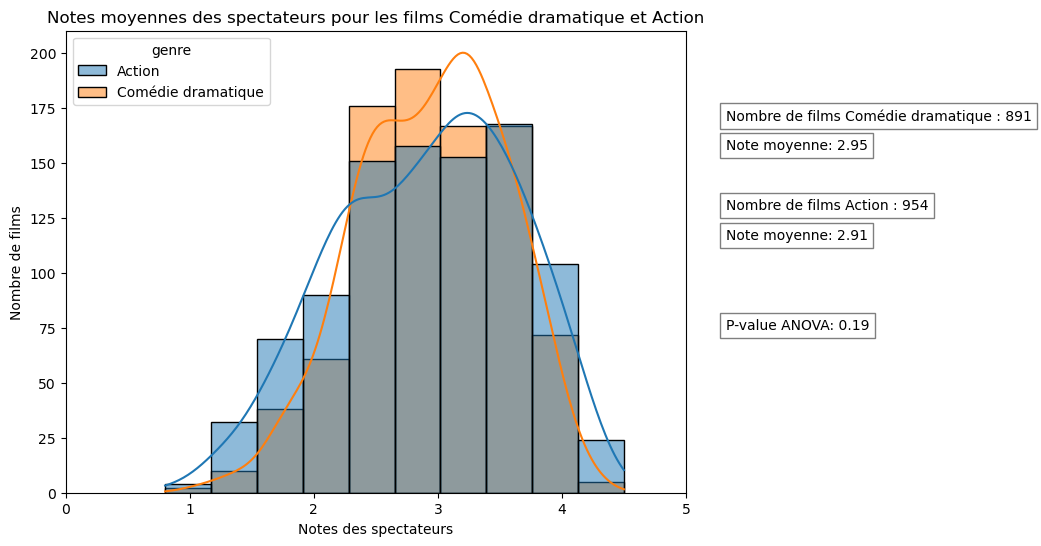

In [ ]:
# Histogrammes de la distribution des notes attribuées par les spectateurs en fonction du genre du film
# => Les menus déroulants permettent de sélectionner différents genres à comparer 
# => Les genres dont nous possédons moins de 50 films ne sont pas pris en compte)                    

graphique_genre_film(table_films)                       

Une p-value du test d'ANOVA très faible (inférieure aux seuils usuels, et notamment de 5%), indique que la différence de notation des spectateurs entre les genres de films peut être considérée comme significative. En étudiant les différentes distributions de notes en fonction des genres ainsi que les tests ANOVA associés, nous pouvons remarquer les points suivants :


- L'ANOVA sur tous les types de films (**p-value < 0.01**) montre qu'il existe bien des **différences significatives** au sein des groupes (au moins un groupe se distingue des autres), cependant cela ne donne aucune information sur quels sont les groupes statistiquement significatifs. Pour cela, nous pouvons par exemple les comparer deux par deux. 


- Pour certains genres de films qui étaient très proche dans le classement, leur p-value montrent que les différences de notations ne sont pas très significatives (Tels que **Action** et **Comédie Dramatique** avec 0,19), voir pas du tout significatives (avec des valeurs de p-value supérieures à 0,6 pour SF et Action par exemple).

- Mais certains genres qui étaient très proches au niveau de la notation moyenne, se retrouvent à avoir des différences de notation qui peuvent être considérées comme statistiquement significatives. C'est notamment le cas du genre **Animation** et **Aventure**, respectivement aux deuxième et troisième places, significatives au seuil de 1%.

- Bien sûr, comme attendu, nous remarquons que plus les 2 genres considérés sont éloignés dans le classement, plus la p-value est significative. 

Les diverses ANOVA réalisées laissent supposer que le type de films semblerait avoir un lien avec la note attribuée par les spectateurs.

### 2) D'autres caractéristiques pourraient-elles avoir une influence sur l'appréciation attribuée par les spectateurs ?

De manière similaire à précédemment nous pouvons effectuer un test **ANOVA** sur le **genre du réalisateur** afin de voir s'il existe une différence significative dans les notes moyennes attribuées aux films réalisés par des femmes et aux films réalisés par des hommes.

In [10]:
p_value_anova_h_vs_f(table_films)

'P-value du test ANOVA: 0.241'

Avec une p-value bien supérieure aux seuils habituels de 1, 5 et 10%, nous pouvons dire qu'il ne semble **pas** y avoir de **différence** statistiquement significative entre les notes attribuées par les spectateurs pour des films réalisés par des femmes et des films réalisés par des hommes. 

Nous pouvons aussi nous pencher sur la durée des films, en traçant le boxpolt des notes en fonction de la durée des films (durées qui ont été discrétisées en intervalle de 10 minutes) : 

========================= Régler le pb avec les bornes SUP

In [ ]:
dataframe_filtre['duree_cat'] = dataframe_filtre['duree_cat'].astype('string')
# # dataframe_filtre['duree_cat'] = dataframe_filtre['duree_cat'].astype('category')
# # 2. Trier les catégories par ordre alphabétique
# # sorted_categories = sorted(dataframe_filtre['duree_cat'].unique())
# category_order = dataframe_filtre.groupby('duree_cat')['duration_min'].mean().sort_values().index.tolist()

# # 3. Appliquer l'ordre trié des catégories
# dataframe_filtre['duree_cat'] = pd.Categorical(dataframe_filtre['duree_cat'], categories=sorted_categories, ordered=True)

/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['duree_cat'] = pd.cut(dataframe[variable], bins=bins, labels=labels, right=False)


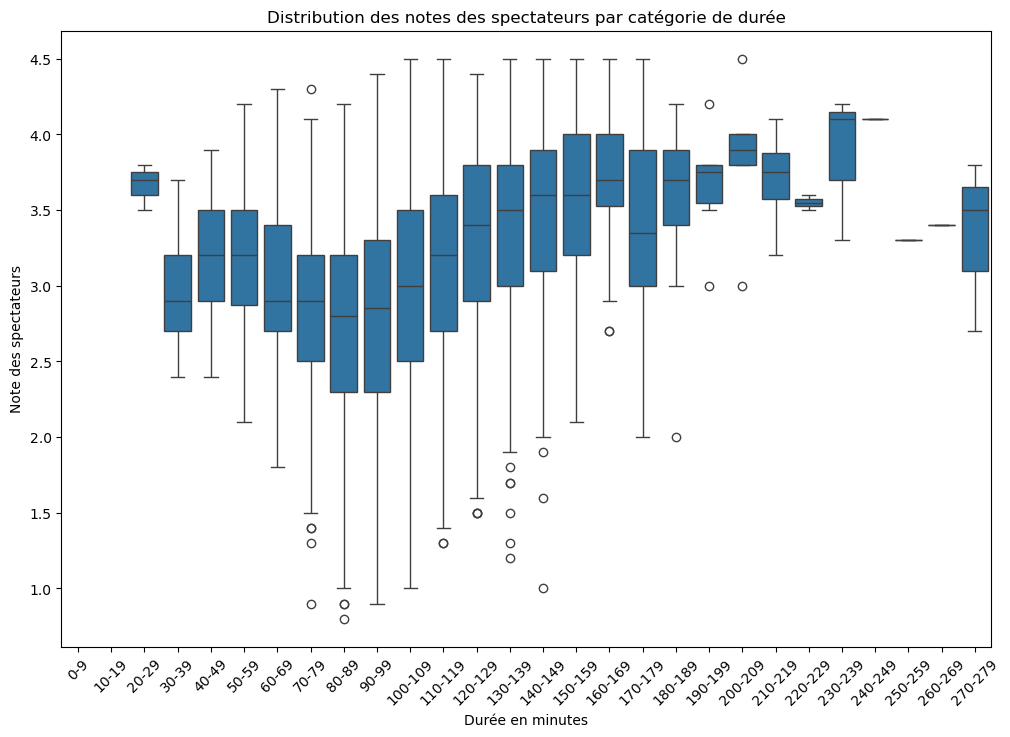

In [89]:
boxplot_duree(table_films, 'duree_cat')

Le boxplot laisse entrevoir deux tendances linéaires : 
- décroissante pour les films de courtes durées jusqu'à 80 minutes
- croissante pour les films avec des durées supérieures à 80 minutes

Cependant, ces tendances ne semblent pas statistiquement significatives.

En se basant sur les récompenses obtenus par les films, nous pouvons regarder la moyenne de la note attribuée aux films qui ont :
- Au moins un prix (éventuellement aussi des nominations)
- Une ou des nominations (mais pas de prix)
- Ni prix, ni nominations

In [13]:
get_moyenne_par_modalite(table_films, 'categorie_recompenses')

categorie_recompenses
prix                 3.311740
nominations          2.993991
aucune récompense    2.863752
Name: spectators_rating, dtype: float64

Nous remarquons que plus les films ont de meilleures récompenses (prix > nominations > rien), plus la note moyenne attribuée par les spectateurs est élevée.

### 3) Les préférences des spectateurs sont-elles similaires à celles de la presse ?

Nous avons précédemment regardé le classement des genres de films les plus appréciés par les spectateurs. Comparons maintenant ce classement à celui de la presse :

In [13]:
comparaison_preferences(table_films)

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.409565,345
Animation,3.248723,509
Drame,3.107265,4143
Aventure,3.073944,568
Policier,3.020175,342
Comédie dramatique,2.946914,891
Action,2.906080,954
Science Fiction,2.854000,50
Thriller,2.792996,257


Le classement se ressemble avec un même quatuor en tête, et même genres de films en queue de classement. 
Cependant les notes moyennes des spectateurs semblent tenir globalement sur un intervalle plus large que celui de la presse.

Dropdown(description='Genre :', index=2, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aventur…

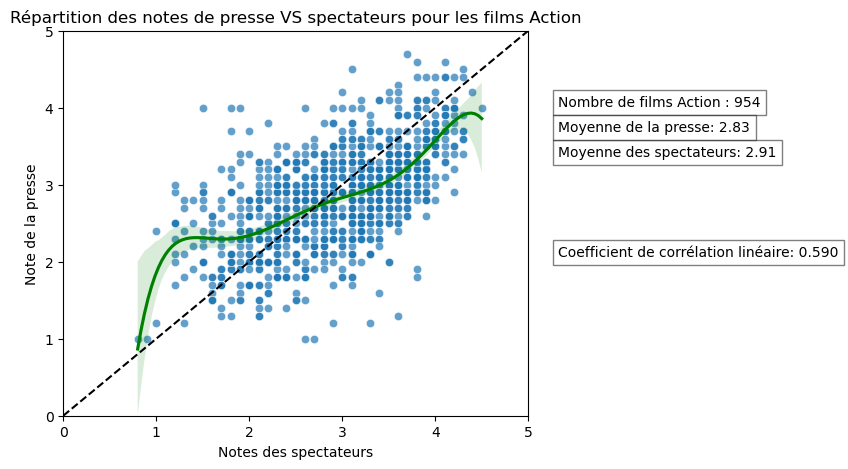

In [14]:
# Nuage de points pour voir les différences de notations entre la presse et les spectateurs
# => Pour chaque graphique, un polynôme en vert représente le polynôme optimal (degré max 6) 
# => Comparer ce poynôme avec la droite x = y (en pointillé) permet de voir si les notes de la presse
# et des spectateurs sont proches ou non
graphique_presse_vs_spect(table_films) 

Pour la plupart des genres de film, nous pouvons observer une **nette plus grande dispersion** des notes des **spectateurs** par rapport à celles de la **press**e. Ce qui refléterait la nature plus **hétérogène/polaire/subjective** des évaluations des spectateurs comparées aux critiques de la presse.

Avec un coefficient de corrélation linéaire de 0,53 (en prenant en compte tous les films), nous avons une **relation positive modérée** entre les notes de la presse et des spectateurs. Nous avons une influence modérée des critiques de presse sur les opinions des spectateurs.

En regardant par type de film, nous nous apercevons que nous pouvons distinguer 3 catégories de films :
- Les films un peu plus corrélés que la moyenne des films (corrélation entre 0,6 et 0,7 pour Aventure, Animation, Epouvante Horreur et Science Fiction)
- Les films corrélés dans la moyenne des films (Policier, Thriller, Comédie et Action)
- Les films très peu corrélés (Comédie dramatique, Biopic, Fantastique et Drame)


Afin d'avoir une analyse plus fine, notamment en terme de budget alloué au film ainsi que le genre du/des réalisateurs nous pouvons agréger à nos films, la base française CNC. Nous perdrons un certains nombre de films, mais en contrepartie cela nous permet d'avoir des variables plus précises pour certaines caractéristiques : notamment sur le(s) genre(s) des réalisateurs ainsi que les budgets alloués aux films.

### 4) Le budget alloué et le genre des réalisateurs peuvent-ils influer sur les notes attribuées par la presse et les spectateurs ? (périmètre d'étude réduit aux films français de la base CNC)

### Base CNC : Analyse du type de devis, obtenus par les réalisateurs vs les réalisatrices

Une base du CNC nous donne ce type d'information : les sociétés productrices et distributrices des films, chaînes de télévision partenaires en préachat. Je veux étudier les différences de montant des devis selon le genre du réalisateur.


In [15]:
# Categorisation des films en fonction du devis
films_cnc = categorisation_devis(films_cnc)


# Ajout d'une variable de genres : attention, cela prend 3 minutes
films_cnc = ajout_genre_multiple(films_cnc, 'realisateur')


In [16]:
films_cnc.head()

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis,genre_ind
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica],entre 4 et 7 m,f
1,127028,DE L'HUILE SUR LE FEU,[BENAMOU Nicolas],AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]",entre 2 et 4 m,m
2,124421,DES JEUNES GENS MODERNES,[DE MISSOLZ Jérôme],ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot],<2 m,m
3,123383,EXERCICE DE L'ETAT (L'),[SCHOELLER Pierre],ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]",entre 4 et 7 m,m
4,124350,MA PART DU GATEAU,[KLAPISCH Cédric],CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",> à 7 m,m


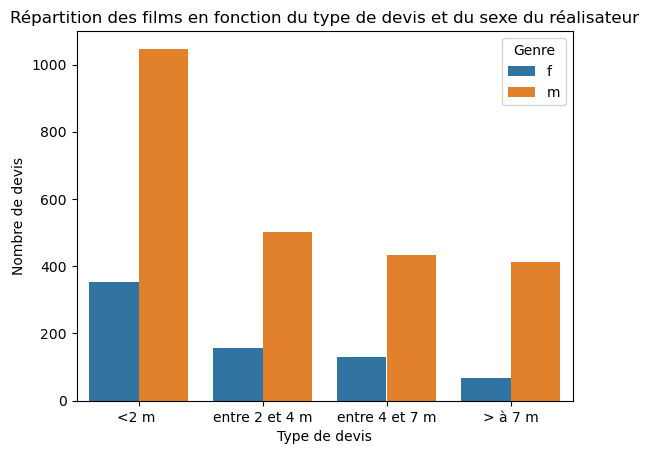

In [17]:

# Filtrer les données pour les modalités 'f' et 'm' de 'genre_ind'
films_cnc_filtered = films_cnc[films_cnc['genre_ind'].isin(['f', 'm'])]

# Créer le barplot avec seaborn
sns.countplot(data=films_cnc_filtered, x='type_de_devis', hue='genre_ind', dodge=True)

# Ajouter des titres et des labels
plt.title('Répartition des films en fonction du type de devis et du sexe du réalisateur')
plt.xlabel('Type de devis')
plt.ylabel('Nombre de devis')
plt.legend(title='Genre')

# Afficher le plot
plt.show()

/tmp/ipykernel_10541/3562478981.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = films_cnc_filtered.groupby(['type_de_devis', 'genre_ind']).size().unstack().fillna(0)


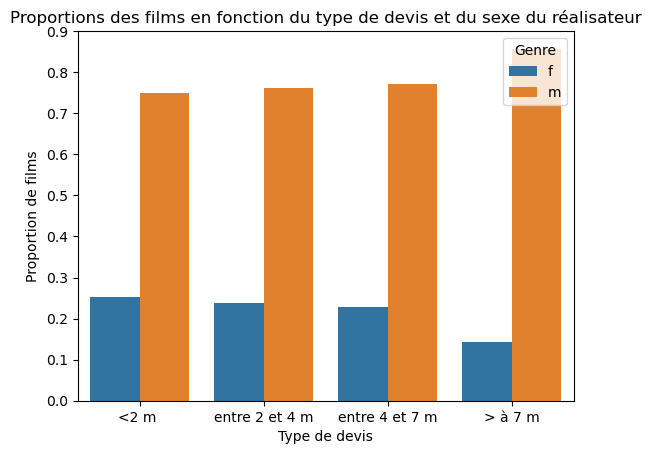

In [18]:

# Filtrer les données pour les modalités 'f' et 'm' de 'genre_ind'
films_cnc_filtered = films_cnc[films_cnc['genre_ind'].isin(['f', 'm'])]

# Calculer les proportions pour chaque catégorie de type_de_devis et genre_ind
proportions = films_cnc_filtered.groupby(['type_de_devis', 'genre_ind']).size().unstack().fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)  # Normaliser par ligne (type_de_devis)

# Réorganiser les données pour un plot avec seaborn
proportions = proportions.reset_index().melt(id_vars=['type_de_devis'], value_name='Proportion')

# Créer le barplot avec seaborn
sns.barplot(data=proportions, x='type_de_devis', y='Proportion', hue='genre_ind')

# Ajouter des titres et des labels
plt.title('Proportions des films en fonction du type de devis et du sexe du réalisateur')
plt.xlabel('Type de devis')
plt.ylabel('Proportion de films')
plt.legend(title='Genre')

# Afficher le plot
plt.show()


### Fusion base CNC et base allociné

In [20]:
base_allocine = table_films.drop(columns=['titre'])
base_cnc_agregee = pd.merge(films_cnc, base_allocine,left_on='visa', right_on='num_visa', how='inner')
len(base_cnc_agregee)
base_cnc_agregee

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,Rolling Stone,Télé 2 semaines,Télé 7 jours,Téléloisirs,Voici,diff_notation,annee,duration_min,duree_cat,categorie_recompenses
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,...,NaN,NaN,NaN,NaN,NaN,0.1,2012,97.0,90-99,prix
1,127028,DE L'HUILE SUR LE FEU,[BENAMOU Nicolas],AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,...,NaN,NaN,NaN,NaN,NaN,0.3,2011,87.0,80-89,rien
2,123383,EXERCICE DE L'ETAT (L'),[SCHOELLER Pierre],ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,...,NaN,NaN,NaN,NaN,NaN,-0.4,2011,112.0,110-119,prix
3,124350,MA PART DU GATEAU,[KLAPISCH Cédric],CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,...,NaN,NaN,NaN,NaN,NaN,-0.1,2011,109.0,100-109,prix
4,122385,MARQUIS (LE),[FARRUGIA Dominique],FARRUDG ENTERTAINMENT WORLDWIDE / PATHE PRODUC...,8880926.0,Fiction,None,3,None,None,...,NaN,NaN,NaN,NaN,NaN,-0.6,2011,88.0,80-89,rien
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,151502,Tlamess,[EDDINE SLIM Ala],STILL MOVING,788017.0,Fiction,NON,3,None,None,...,NaN,NaN,NaN,NaN,NaN,-0.5,2020,120.0,120-129,rien
2839,141793,D'une pierre deux coups,[DELIBA Fejria],CINE SUD PROMOTION,1219623.0,Fiction,None,1,avant,None,...,NaN,NaN,NaN,NaN,NaN,-0.3,2016,83.0,80-89,rien
2840,138716,Irremplaçable,[LILTI Thomas],31 JUIN FILMS / FRANCE 2 CINEMA / LES FILMS DU...,5345262.0,Fiction,None,3,None,"[C+, Ciné+]",...,NaN,NaN,NaN,NaN,NaN,-0.1,2016,102.0,100-109,rien
2841,132961,Orpheline,[DES PALLIERES Arnaud],CENTRE EUROPEEN CINEMATOGRAPHIQUE RHONE ALPES ...,4629334.0,Fiction,None,3,avant,"[C+, Ciné+]",...,NaN,NaN,NaN,NaN,Pas mal,-0.6,2017,111.0,110-119,nominations


In [21]:
# Conversion des notes en écriture décimale

base_cnc_agregee['spectators_rating']= base_cnc_agregee['spectators_rating'].apply(mise_en_forme_decimale)
base_cnc_agregee['press_rating'] = base_cnc_agregee['press_rating'].apply(mise_en_forme_decimale)


In [22]:
print(base_cnc_agregee[['spectators_rating', 'press_rating']].dtypes)

spectators_rating    float64
press_rating         float64
dtype: object


In [23]:
#Comparaison avis spectateurs vs presse selon le type de devis
base_cnc_agregee_moyennes = base_cnc_agregee.groupby("type_de_devis").agg(
    presse=('press_rating', "mean"),
    spectateur=('spectators_rating', "mean")
).reset_index()
base_cnc_agregee_moyennes

/tmp/ipykernel_10541/478869799.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_cnc_agregee_moyennes = base_cnc_agregee.groupby("type_de_devis").agg(


,type_de_devis,presse,spectateur
0,<2 m,3.116203,2.850199
1,entre 2 et 4 m,3.189173,2.832481
2,entre 4 et 7 m,3.126592,2.887079
3,> à 7 m,2.933669,2.783871


In [27]:
histogramme_genre_film(base_cnc_agregee, "Action", "Policier")

ValueError: cannot reindex on an axis with duplicate labels

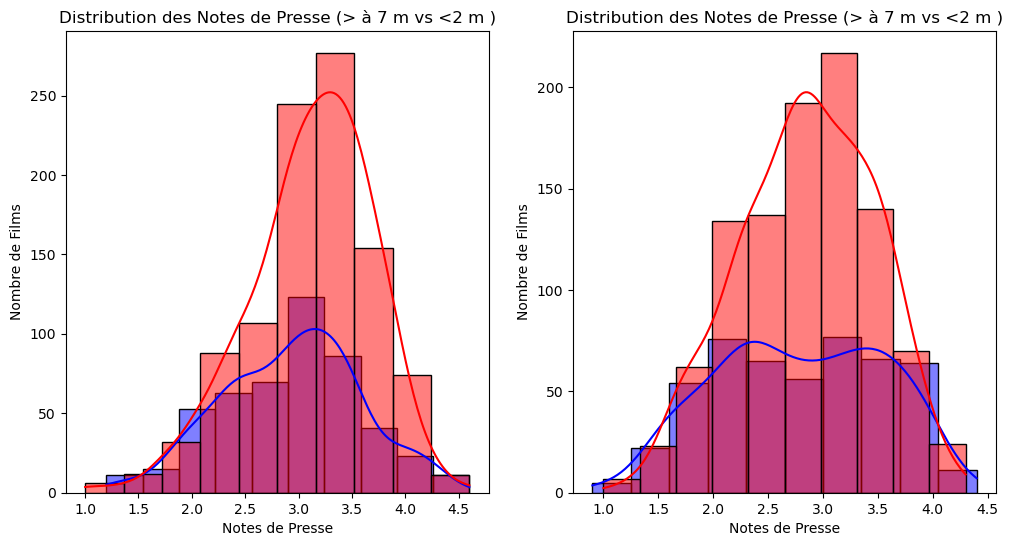

In [ ]:


def histogramme_devis(dataframe, categorie1, categorie2) : 
 fig, axes = plt.subplots(1,2, figsize=(12, 6))

 dataframe = dataframe[dataframe['type_de_devis'].isin([categorie1, categorie2])]
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie1], x='press_rating', color='blue', kde=True, stat='count', label=categorie1, bins=10, alpha=0.5, ax = axes[0])
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie2], x='press_rating', color='red', kde=True, stat='count', label=categorie2, bins=10, alpha=0.5, ax = axes[0])

 axes[0].set_title(f'Distribution des Notes de Presse ({categorie1} vs {categorie2})')
 axes[0].set_xlabel('Notes de Presse')
 axes[0].set_ylabel('Nombre de Films')
#  axes[0].set_legend(title='Type de Devis')


 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie1], x='spectators_rating', color='blue', kde=True, stat='count', label=categorie1, bins=10, alpha=0.5, ax = axes[1])
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie2], x='spectators_rating', color='red', kde=True, stat='count', label=categorie2, bins=10, alpha=0.5, ax = axes[1])

 axes[1].set_title(f'Distribution des Notes de Presse ({categorie1} vs {categorie2})')
 axes[1].set_xlabel('Notes de Presse')
 axes[1].set_ylabel('Nombre de Films')
#  axes[1].set_legend(title='Type de Devis')


histogramme_devis(base_cnc_agregee, "> à 7 m", "<2 m " )



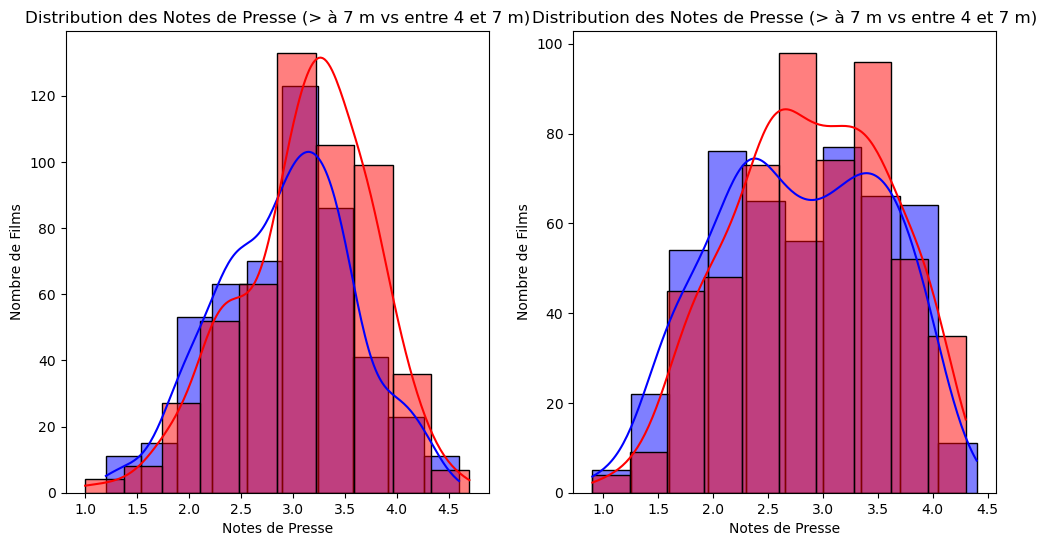

In [41]:
histogramme_devis(base_cnc_agregee, "> à 7 m", "entre 4 et 7 m" )

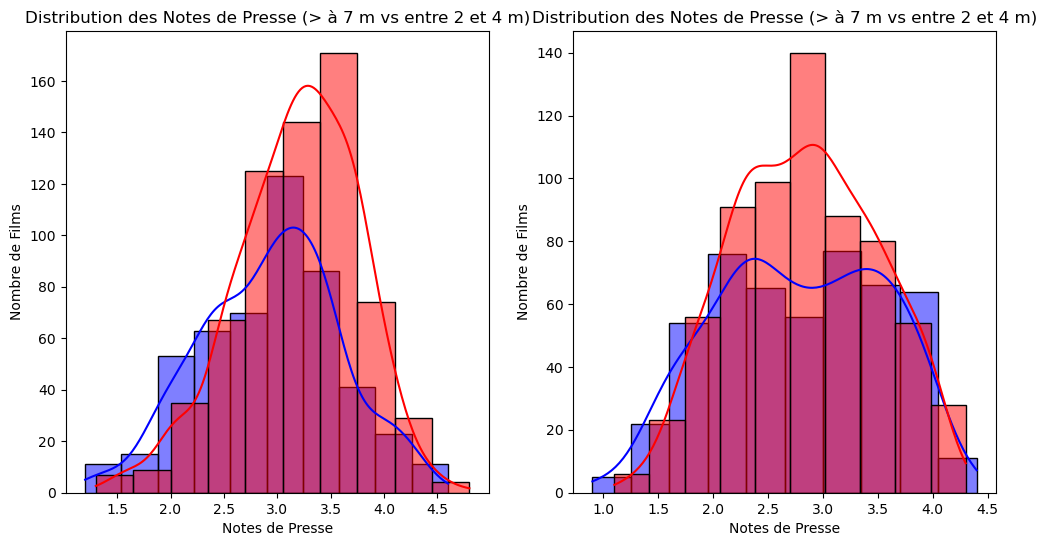

In [42]:
histogramme_devis(base_cnc_agregee, "> à 7 m", "entre 2 et 4 m" )

In [ ]:

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns




#############################################################  Histogramme de la distribution des notes des spectateurs par type de film


def histogramme_genre_film_version_Lyna(dataframe, modalité1, modalité2):
    """
    Génération d'un histogramme des notes des spectateurs par GENRE1 et GENRE2 de films

    """
    dataframe = dataframe.rename(columns={'modalité1': 'genre'})

    if genre1 != 'Tous':

        if genre2 != ' ':
            dataframe = dataframe[dataframe['genre'].isin([genre1, genre2])]
            if genre1 != ' ':
                titre = f'Notes moyennes des spectateurs pour les films {genre1} et {genre2}'
            else:
                titre = f'Notes moyennes des spectateurs pour les films {genre2}'

        else:
            dataframe = dataframe.loc[dataframe['genre'] == genre1]
            titre = f'Notes moyenne des spectateurs pour les films {genre1}'

          
    else:
        if genre2 != ' ':
            print('Merci de choisir un Genre 1 pour comparer avec le Genre 2')
            
        titre = 'Notes moyennes des spectateurs par type de film'


    if genre1 != ' ' or genre2 != ' ':
        plt.figure(figsize=(8, 6))

        sns.histplot(data=dataframe, x='spectators_rating', hue='genre', bins=10, kde=True)
        plt.title(titre)
        plt.xlabel('Notes des spectateurs')
        plt.ylabel('Nombre de films')
        plt.xlim(0, 5)


        # Ajout du nombre de films pris en compte ainsi que la note moyenne des spectateurs
        if genre1 != 'Tous' and genre2 != ' ' and genre1 != genre2:
            
            nb_films_1 = len(dataframe.loc[dataframe['genre'] == genre1])
            moyenne_1 = dataframe.loc[dataframe['genre'] == genre1]['spectators_rating'].mean()

            nb_films_2 = len(dataframe.loc[dataframe['genre'] == genre2])
            moyenne_2 = dataframe.loc[dataframe['genre'] == genre2]['spectators_rating'].mean()
            
            if genre1 != ' ':
                plt.text(0.95, 0.75, f'Nombre de films {genre1} : {nb_films_1}', transform=plt.gcf().transFigure, horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

                plt.figtext(0.95, 0.70, f'Note moyenne: {moyenne_1:.2f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

            plt.text(0.95, 0.60, f'Nombre de films {genre2} : {nb_films_2}', transform=plt.gcf().transFigure, horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

            plt.figtext(0.95, 0.55, f'Note moyenne: {moyenne_2:.2f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))


        else:
            nb_films = len(dataframe)
            moyenne = dataframe['spectators_rating'].mean()
            plt.text(0.95, 0.75, f'Nombre de films : {nb_films}', transform=plt.gcf().transFigure, horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

            plt.figtext(0.95, 0.70, f'Note moyenne: {moyenne:.2f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))




        # test ANOVA (singificativité de différence dans les moyennes de chaque type de films)
        if genre2 != ' ' or genre1 == 'Tous':
            if genre1 != ' 'and genre1 != genre2:
                model = ols('spectators_rating ~ C(genre)', data=dataframe).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                # Affchage de la p-value
                plt.figtext(0.95, 0.40, f'P-value ANOVA: {anova_table.iloc[0]['PR(>F)']:.2f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
        





def graphique_genre_film(dataframe):
    """
    Créer une interface avec deux menus déroulants pour sélectionner les genres de films 
    dont on veut comparer la distribution des notes (visualisation histogramme)

    """

    modalites_presentes = dataframe['genre1'].value_counts()

    # On ne représente que les modalités qui sont présentes en un nombre suffisant de fois (nombre fixé à 50)
    modalites_suffisantes = list(modalites_presentes[modalites_presentes >= 50].index) 
    modalites_suffisantes.append('Tous')
    modalites_suffisantes.append(' ')


    # Boutons de sélection

    # Genre 1
    menu_deroulant_1 = widgets.Dropdown(
        options=modalites_suffisantes,
        value='Tous',  # valeur initiale
        description='Genre 1 :',
    )

    # Genre 2
    menu_deroulant_2 = widgets.Dropdown(
        options=[genre for genre in modalites_suffisantes if genre != 'Tous'],
        value=' ',   # valeur initiale
        description='Genre 2 :',
    )



    # Fonctions de mise à jour
    def update_genre_1(change):

        if change['type'] == 'change' and change['name'] == 'value':
            print(f"Genre 1 changé en : {change['new']}")  
            clear_output(wait=True) # suppression de l'ancien graphique pour pouvoir le remplacer

            display(menu_deroulant_1)
            display(menu_deroulant_2)

            histogramme_genre_film(dataframe, change['new'], menu_deroulant_2.value)

    def update_genre_2(change):

        if change['type'] == 'change' and change['name'] == 'value':
            print(f"Genre 2 changé en : {change['new']}")  # Débogage
            clear_output(wait=True)

            display(menu_deroulant_1)
            display(menu_deroulant_2)
            
            histogramme_genre_film(dataframe, menu_deroulant_1.value, change['new'])



    # Association des menus déroulants à leur fonction de mise à jour
    menu_deroulant_1.observe(update_genre_1, names='value')
    menu_deroulant_2.observe(update_genre_2, names='value')



    # Affichage des menus déroulants et le graphe initial
    display(menu_deroulant_1)
    display(menu_deroulant_2)
    histogramme_genre_film(dataframe, menu_deroulant_1.value, menu_deroulant_2.value)



In [24]:
#Comparaison avis spectateurs vs presse selon le type de devis et le genre
base_cnc_agregee_moyennes = base_cnc_agregee.groupby(
    ["type_de_devis", "genre_ind"]
).agg(
    presse=('press_rating', "mean"),
    spectateur=('spectators_rating', "mean")
).reset_index()
base_cnc_agregee_moyennes

KeyError: 'genre_ind'

Le résultat des notes n'est pas incroyable. En tout cas, elles ne semblent rien dire sur une réception différenciée des films réalisés par des femmes, par opposition à des films réalisés par des hommes... Ainsi peut-on conclure que la critique n'est pas sexiste ?

In [38]:
base_cnc_agregee_f = base_cnc_agregee.query("genre_ind == 'f'")
base_cnc_agregee_f

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,date_sortie_bluray,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,...,-,21/07/2012,Long métrage,4 500 000 EUR,Français,"35mm, Super 8",Couleur,Dolby Digital,1.85 : 1,117042
22,149287,Une fille facile,[ZLOTOWSKI Rebecca],LES FILMS VELVET,2684638.0,Fiction,OUI,3,None,[C+],...,21/01/2020,14/01/2020,Long métrage,-,Français,-,Couleur,-,-,149287
28,142598,Moutonnière (La),[DJAMA Sofia],LIAISON CINEMATOGRAPHIQUE,1152380.0,Fiction,OUI,1,avant,[Ciné+],...,-,24/04/2018,Long métrage,-,ARABIC,-,Couleur,-,-,142598
33,133830,ABUS DE FAIBLESSE,[BREILLAT Catherine],ARTE FRANCE CINEMA / CB FILMS / FLACH FILM / F...,3984660.0,Fiction,None,3,avant,None,...,-,03/09/2014,Long métrage,-,Français,-,Couleur,-,-,133830
39,131183,DARK TOUCH,[DE VAN Marina],EX NIHILO,2729542.0,Fiction,None,3,None,None,...,-,01/03/2020,Long métrage,2 729 542 EUR,Anglais,-,Couleur,-,-,131183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,151976,A la folie,[ESTROUGO Audrey],DAMNED FILMS,148741.0,Fiction,OUI,3,après,None,...,-,06/08/2022,Long métrage,-,Français,-,Couleur,-,-,151976
2147,152335,Amours d'Anaïs (Les),[BOURGEOIS-TACQUET Charline],LFP - LES FILMS PELLÉAS,3098451.0,Fiction,OUI,1,avant,"[C+, Ciné+]",...,-,13/12/2021,Long métrage,-,Français,-,Couleur,-,-,152335
2153,153199,Portrait d'une jeune fille qui va bien,[KIBERLAIN Sandrine],CURIOSA FILMS / E.D.I FILMS,3732502.0,Fiction,OUI,1,None,"[C+, Ciné+]",...,07/06/2022,06/06/2022,Long métrage,-,Français,-,Couleur,-,-,153199
2157,151526,Parent d'élève,[SAGLIO Noémie],RECTANGLE PRODUCTIONS,4625760.0,Fiction,OUI,3,None,"[C+, Ciné+]",...,-,10/02/2021,Long métrage,-,Français,-,Couleur,-,-,151526


In [44]:
#Je regarde la différence de notation selon le genre du film, le genre du réal

classement_genres_preferes(base_cnc_agregee_f, 'spectateur')

ValueError: Grouper for 'genre' not 1-dimensional

In [45]:
presse.head()
base_cnc_agregee_presse = pd.merge(base_cnc_agregee, presse,left_on='identifiant', right_on='identifiant', how='inner')

## III - Modelisation

### 1) Spectateurs (Regression)
La première analyse descriptive montre que l'on distingue différents facteurs qui pourraient expliquer des différentes notes attribuées par les spectateurs. Nous pouvons voir si un modèle permettrait d'expliquer et prédire les notes des spectateurs en se basant sur divers critères, tels que le genre, la durée ou encore les récompenses obtenus.  

In [15]:
# Suppression des lignes qui n'ont pas de durée renseignée (seulement 24 sur les 10837 films)
table_regression = table_films.dropna(subset=['duration_min'])

# Filtrage des modalités de genre de films présents plus de 50 fois 
modalites_conservees = classement_genres_preferes(table_regression, 'spectators_rating').index.tolist()
table_regression = table_regression[table_regression['genre1'].isin(modalites_conservees)]

In [20]:
# test de normalité de la distribution des notes
stat, p_value = shapiro(table_films['spectators_rating'])
print('p-value :', p_value)

p-value : 2.6021836323601493e-31


La très faible p-value montre que nous pouvons fortement rejeter l'hypothèse de normalité des données. La regression se fera ainsi avec la normalisation des notes.

MSE : 0.3673
R² : 0.1950

ATTENTION : les coefficients sont ceux de la régression avec les notes normalisées.

              Variable  Coefficient  Lower CI  Upper CI
0            Animation     0.811082  0.690008  0.932157
12                prix     0.553885  0.500058  0.607712
2               Biopic     0.549177  0.416012  0.682342
1             Aventure     0.309898  0.198051  0.421745
5                Drame     0.294323  0.216564  0.372082
15        duration_min     0.210884  0.189717  0.232050
8             Policier     0.151981  0.016273  0.287690
4   Comédie dramatique     0.136580  0.037063  0.236097
11         nominations     0.127000  0.070529  0.183471
13                 f,m    -0.005163 -0.112924  0.102597
14                   m    -0.053141 -0.096713 -0.009570
10            Thriller    -0.084833 -0.234912  0.065246
9      Science Fiction    -0.151817 -0.479129  0.175495
3              Comédie    -0.201872 -0.285391 -0.118354
6    Epouvante-horreur    -0.445212 -0.590536 -0.

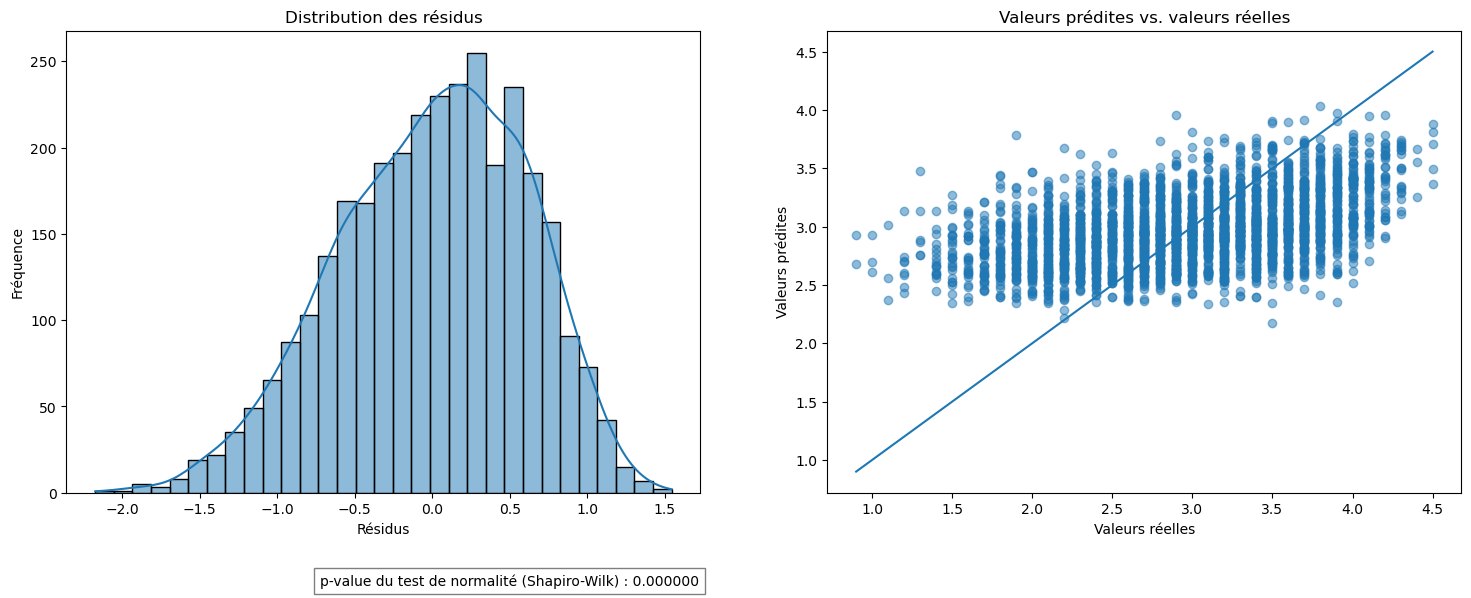

In [21]:
regression(table_regression)

Afin de gérer les variables discrètes, dans la regression chaque modalité fait l'objet d'une variable binaire. Les modalités de références (utilisées comme base de comparaison, non présentes, elles n'ont pas de coefficients afin de ne pas avoir de problème de multicolinéarité) sont :
genre **Action**, avoir une réalisatrice **f**, avoir reçu une/des **nominations**.
Les **coefficients** de la régression (coefficients avec variable cible normalisée), montrent que : 
- Certains coefficients ne sont pas statistiquement significatifs (leur intervalles de confiance à 95% incluent 0) : *Ex : Le fait d'être un Thriller par rapport à Action*
- Certains coefficients sont statistiquement significatifs mais ont un poids assez faible : *Ex : Le fait d'avoir un réalisateur par rapport à une réalisatrice*
- Les coefficients qui semblent avoir la plus grande importance concernent :
    - Les genres  **Animation, Biopic** semblent avoir un impact positif significativement plus grand sur les notes par rapport au genre de référence Action. Idem pour les genres       **Epouvante-horreur, et Fantastique** mais négativement.
    - Le fait d'avoir reçu un **prix**, semblent avoir un impact positif significativement plus grand sur les notes par rapport au fait d'avoir reçu au moins une nomination.

Les **métriques** du modèle, nous donnent d'autres informations :

- La **MSE** (erreur quadratique moyenne) de 0.367 (pour des notes (variable cible) comprises entre 1 et 5) montre que les erreurs de prédiction sont relativement faibles : En moyenne, les notes prédites sont à environ 0.367 unités de leur valeur réelle. 

- Cependant avec un **R²** (proportion de la variance des notes des spectateurs expliquée par les variables du modèle) relativement faible, de 0.195, indique que seulement environ 19.5% de la variance des notes est expliquée par le modèle. 


Cette situation avec une plutôt bonne MSE mais un R² assez faible, pourrait s'expliquer par une **faible variabilité des notes autour de leurs moyennes** (Cf Premiers histogrammes de la partie II Analyses descriptives). Enraînant mécaniquement de **Relativement bons résultats en MSE**. Les valeurs prédites sont ainsi toutes très proches (comprises principalement dans l'interval [2.2, 3.7]) comme visible sur le graphique **Valeurs prédites vs valeurs réelles**.
Cependant ce modèle n'explique par la variabilité des données d'où un **faible R²**. 


De ce fait nous ne pouvons pas dire que ce modèle soit très pertinent.


### 2) Presse (Clustering)
Concernant la presse, et au vue des résultats nous pouvons nous demander si on ne pourrait pas identifier des groupe de presse en fonction de leur notes attribuées en fonction des films.


In [15]:
# Mise en forme de la table qui sera utilisée pour le clustering : calcul pour chaque presse des notes attribuées pour genre de film et genre du réalisateur.
table_cluster = get_table_cluster(table_films, presse_notes)

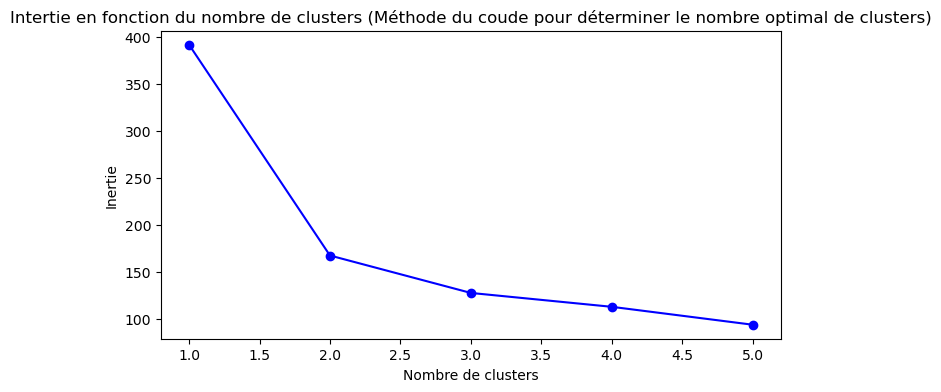

Graphiquement le nombre optimal de clusters est : 2


In [16]:
nb_clusters_optimal = determine_optimal_clusters(table_cluster, 5)

In [17]:
# clustering par méthode K-means avec 2 clusters :
clusters = clustering_K_means(table_cluster,2)

for cluster, presse in clusters.items():
    print(f"Cluster {cluster}: {list(presse)}")

Cluster 0: ['Transfuge', 'Bande à part', 'LCI', 'CNews', 'Les Echos', 'Le Parisien', 'Le Point', 'Marianne', 'Closer', 'Elle', 'GQ', 'Paris Match', 'Public', 'Rolling Stone', 'Télé 2 semaines', 'Voici']
Cluster 1: ['Mad Movies', 'Positif', 'Première', 'Télérama', 'Filmsactu', 'Charlie Hebdo', 'La Croix', 'Le Dauphiné Libéré', 'Le Figaro', 'Le Monde', 'Libération', 'Ouest France']


In [ ]:
# Visualisation des moyennes des différentes variables étudiées en fonction des groupes.
table_cluster.groupby('Cluster').mean()

,f,m,Action,Animation,Aventure,Biopic,Comédie,Comédie dramatique,Drame,Epouvante-horreur,Fantastique,Policier,Science Fiction,Thriller
Cluster,,,,,,,,,,,,,,
0,3.729384,3.729735,3.415697,4.022534,3.747914,3.797584,3.666977,3.751094,3.843527,3.555879,3.418696,3.802601,3.569167,3.573584
1,3.164099,3.130441,2.863428,3.525669,3.158209,3.345068,2.993609,3.234813,3.300815,2.780921,2.949182,3.193239,3.000258,2.961190


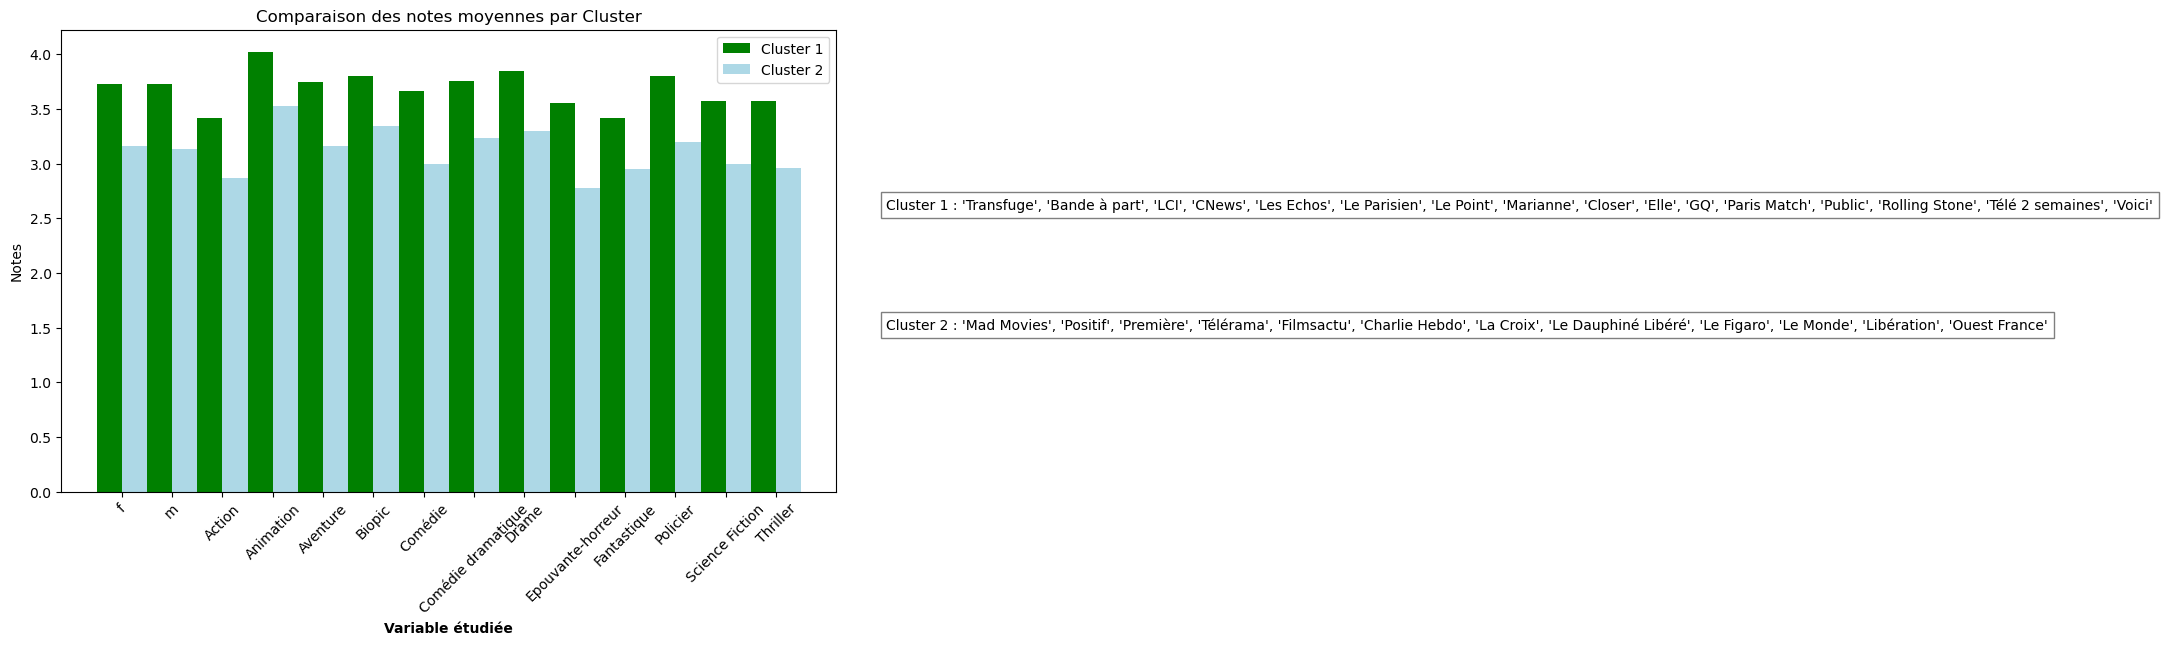

In [169]:
graphe_cluster(table_cluster)

Le Cluster 1 est composé de presse qui donnent globalement les notes les plus élevées.
======== blablabla
